<a href="https://colab.research.google.com/github/restevesd/Coursera_Capstone/blob/master/FinalBGpuntosdeatencion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importamos librerias

In [2]:
!pip install reverse_geocoder
!pip install geopy
!pip install folium

print("Librerías instaladas")

     |████████████████████████████████| 2.3MB 9.7MB/s 
  Created wheel for reverse-geocoder: filename=reverse_geocoder-1.5.1-cp36-none-any.whl size=2268090 sha256=fbbfdbeb4048830dc0165441c43de14fdd4f298329981ad4258238fd56c969c1
  Stored in directory: /root/.cache/pip/wheels/47/05/50/b1350ff094ef91e082665b4a2f9ca551f8acea4aa55d796b26
Successfully built reverse-geocoder
Librerías instaladas


In [31]:
import numpy as np
import reverse_geocoder as rg 

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 

import requests
from pandas.io.json import json_normalize # Transformar Json a DataFrames

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # 
import folium # Mapas

import matplotlib.pyplot as plt
import seaborn as sb

print('Libraries imported.')

Libraries imported.


### Importamos el archivo de puntos de atención de Banco Guayaquil

In [4]:
data = pd.read_csv('limpioDataSet.csv', error_bad_lines=False,sep=";") 
data.head()

,Codigo,CodTipo,Tipo,coordenadas
0,79,1,Cajeros Automáticos,"-79.880615,-2.189985"
1,80,1,Cajeros Automáticos,"-79.879924,-2.191144"
2,81,1,Cajeros Automáticos,"-79.879511,-2.187539"
3,82,1,Cajeros Automáticos,"-79.898076,-2.181847"
4,83,1,Cajeros Automáticos,"-79.907486,-2.172754"


### Limpio el dataframe y separo las coordenadas en longitu y latitud

In [0]:
data.dropna(inplace = True) 
  
new = data["coordenadas"].str.split(",", n = 1, expand = True) 
   
data["longitud"]= new[0] 
  
data["latitud"]= new[1] 
  
data.drop(columns =["coordenadas"], inplace = True) 

### Validamos que los nombres de columna estén correctos

In [136]:
data.columns

Index(['Codigo', 'CodTipo', 'Tipo', 'longitud', 'latitud', 'ciudad'], dtype='object')

In [137]:
print('El dataframe tiene {} tipos de puntos de atención and {} ubicaciones.'.format(
        len(data['Tipo'].unique()),
        data.shape[0]
    )
)

El dataframe tiene 3 tipos de puntos de atención and 812 ubicaciones.


### Agregamos al dataframe de puntos de atención la ciudad en base a sus coordenandas

In [8]:
address = 'Guayaquil, Ecuador'

geolocator = Nominatim(user_agent="gye_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Las coordenadas de Guayaquil son {}, {}.'.format(latitude, longitude))

Las coordenadas de Guayaquil son -2.1898771, -79.8877153.


In [0]:
# Iteración por filas del DataFrame:
ciudad = "Guayaquil"
data["ciudad"] = ciudad

In [0]:
i=0
for indice_fila in data.iterrows():
  longitud = indice_fila[1]["longitud"]
  latitud = indice_fila[1]["latitud"]
  coordinates =(latitud, longitud) 
  result = rg.search(coordinates) 
  data["ciudad"][i] = result[0]["name"]
  i = i + 1 

In [0]:
guayaquil_data = data[data['ciudad'] == 'Guayaquil'].reset_index(drop=True) # Construyo un dataframe solo para Guayaquil
guayaquil_data.head()
guayaquil_data[['longitud', 'latitud']] = guayaquil_data[['longitud', 'latitud']].astype(float) 


In [12]:
len(guayaquil_data)

159

In [13]:
map_gye = folium.Map(location=[latitude, longitude], zoom_start=12)
# cada tipo de un color diferente
x = np.arange(3)
ys = [i + x + (i*x)**2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# añado marcadores al mapa
for lat, lng, label,codTipo in zip(guayaquil_data['latitud'], guayaquil_data['longitud'], guayaquil_data['Tipo'],guayaquil_data["CodTipo"]):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color=rainbow[codTipo-1],
        fill=True,
        fill_color=rainbow[codTipo-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_gye)  
    
  
    
map_gye

### Trabajo con 4square

In [0]:
CLIENT_ID = 'L3OJGFIAY2O3KWEHVYYKKULP2LMPA5RZ0JDVQYM1GYJGHTKC' # your Foursquare ID
CLIENT_SECRET = 'AUDQYCWOJT3JCTS4PHXELU4JZQJX4ECDVHKBVHZNGO2CMBJO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [15]:
guayaquil_data.head(1)

,Codigo,CodTipo,Tipo,longitud,latitud,ciudad
0,82,1,Cajeros Automáticos,-79.898076,-2.181847,Guayaquil


In [17]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
punto_latitud = -2.181847
punto_longitud = -79.898076

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    punto_latitud, 
    punto_longitud, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=L3OJGFIAY2O3KWEHVYYKKULP2LMPA5RZ0JDVQYM1GYJGHTKC&client_secret=AUDQYCWOJT3JCTS4PHXELU4JZQJX4ECDVHKBVHZNGO2CMBJO&v=20180605&ll=-2.181847,-79.898076&radius=500&limit=100'

In [0]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [0]:
def getNearbyVenues(ide,names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for ide,name, lat, lng in zip(ide,names, latitudes, longitudes):    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            ide,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['id', 
                  'Tipo',
                  'Latitud', 
                  'Longitud', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [0]:
guayaquil_venues = getNearbyVenues(ide=guayaquil_data['Codigo'],
                                   names=guayaquil_data['Tipo'],
                                   latitudes=guayaquil_data['latitud'],
                                   longitudes=guayaquil_data['longitud']
                                  )

In [138]:
print(guayaquil_venues.shape)
guayaquil_venues.head()

(3081, 8)


,id,Tipo,Latitud,Longitud,Venue,Venue Latitude,Venue Longitude,Venue Category
0,82,Cajeros Automáticos,-2.181847,-79.898076,Gimnasio Nautilus,-2.178654,-79.897939,Gym
1,82,Cajeros Automáticos,-2.181847,-79.898076,Sweet & Coffee Malecón del Salado,-2.185790,-79.897588,Coffee Shop
2,82,Cajeros Automáticos,-2.181847,-79.898076,Queens Dim Sim,-2.181867,-79.893975,Dim Sum Restaurant
3,82,Cajeros Automáticos,-2.181847,-79.898076,Sarao Centro Cultural,-2.177524,-79.898088,Theater
4,82,Cajeros Automáticos,-2.181847,-79.898076,Chacon Print,-2.182119,-79.895978,Paper / Office Supplies Store


In [141]:
# one hot encoding
gye_onehot = pd.get_dummies(guayaquil_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
gye_onehot['id'] = guayaquil_venues['id'] 

# move neighborhood column to the first column
fixed_columns = [gye_onehot.columns[-1]] + list(gye_onehot.columns[:-1])
gye_onehot = gye_onehot[fixed_columns]

gye_onehot.head()

,id,Accessories Store,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Auto Garage,BBQ Joint,Bakery,Bar,Baseball Stadium,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Garden,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Caribbean Restaurant,Chinese Restaurant,Church,Clothing Store,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Empanada Restaurant,Fabric Shop,Falafel Restaurant,Fast Food Restaurant,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Historic Site,History Museum,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kosher Restaurant,Latin American Restaurant,Lighthouse,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Office,Optical Shop,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Planetarium,Plaza,Pool,Pool Hall,Professional & Other Places,Pub,Recording Studio,Rest Area,Restaurant,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,South Indian Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Swiss Restaurant,Taco Place,Tea Room,Tex-Mex Restaurant,Theater,Toy / Game Store,Tunnel,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Volleyball Court,Warehouse Store,Wings Joint,Women's Store
0,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [139]:
gye_onehot.shape

(28, 17)

In [142]:
guayaquil_grouped = gye_onehot.groupby('id').mean().reset_index()
guayaquil_grouped

,id,Accessories Store,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Auto Garage,BBQ Joint,Bakery,Bar,Baseball Stadium,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Garden,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Caribbean Restaurant,Chinese Restaurant,Church,Clothing Store,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Empanada Restaurant,Fabric Shop,Falafel Restaurant,Fast Food Restaurant,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Historic Site,History Museum,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kosher Restaurant,Latin American Restaurant,Lighthouse,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Office,Optical Shop,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Planetarium,Plaza,Pool,Pool Hall,Professional & Other Places,Pub,Recording Studio,Rest Area,Restaurant,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,South Indian Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Swiss Restaurant,Taco Place,Tea Room,Tex-Mex Restaurant,Theater,Toy / Game Store,Tunnel,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Volleyball Court,Warehouse Store,Wings Joint,Women's Store
0,2,0.000000,0.014085,0.000000,0.028169,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042254,0.00,0.000000,0.000000,0.000000,0.014085,0.000000,0.000000,0.000000,0.000000,0.042254,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.042254,0.000000,0.000000,0.028169,0.014085,0.000000,0.0,0.014085,0.0,0.000000,0.000000,0.000000,0.014085,0.000000,0.000000,0.000000,0.014085,0.000000,0.000000,0.000000,0.000000,0.000000,0.028169,0.000000,0.000000,0.014085,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014085,0.00,0.000000,0.000000,0.014085,0.014085,0.000000,0.000000,0.000000,0.000000,0.014085,0.000000,0.000000,0.000000,0.028169,0.000000,0.042254,0.028169,0.000000,0.014085,0.014085,0.014085,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014085,0.000000,0.014085,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.014085,0.000000,0.000000,0.000000,0.000000,0.014085,0.014085,0.000000,0.000000,0.014085,0.014085,0.070423,0.000000,0.000000,0.00,0.000000,0.000000,0.028169,0.00,0.000000,0.028169,0.070423,0.000000,0.000000,0.042254,0.000000,0.000000,0.000000,0.028169,0.000000,0.000000,0.028169,0.00,0.000000,0.014085,0.000000,0.000000,0.028169,0.000000,0.000000,0.042254,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014085
1,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.150000,0.00,0.0,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [0]:
num_top_venues = 5

for hood in guayaquil_grouped['id']:
    print(hood)
    temp = guayaquil_grouped[guayaquil_grouped['id'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

In [0]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [0]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['id']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['id'] = guayaquil_grouped['id']

for ind in np.arange(guayaquil_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(guayaquil_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

In [39]:
# set number of clusters
kclusters = 2

guayaquil_grouped_clustering = guayaquil_grouped.drop('id', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(guayaquil_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [0]:
guayaquil_grouped_clustering

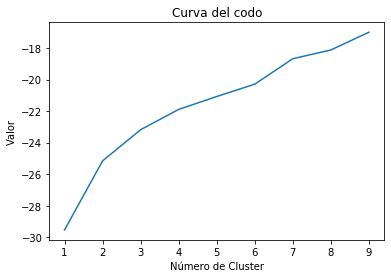

In [38]:

Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(guayaquil_grouped_clustering).score(guayaquil_grouped_clustering) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Número de Cluster')
plt.ylabel('Valor')
plt.title('Curva del codo')
plt.show()

In [40]:
neighborhoods_venues_sorted = neighborhoods_venues_sorted.rename(columns={'id':'Codigo'})
neighborhoods_venues_sorted.columns

Index(['Codigo', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

In [0]:
guayaquil_merged=[]
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_.astype(int))

In [0]:
neighborhoods_venues_sorted

In [0]:
guayaquil_merged = guayaquil_data

In [0]:
# merge guayaquil_grouped with guayaquil_data to add latitude/longitude for each codigo
guayaquil_merged = pd.merge(guayaquil_merged, neighborhoods_venues_sorted, on='Codigo')

In [143]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(guayaquil_merged['latitud'], guayaquil_merged['longitud'], guayaquil_merged['Tipo'], guayaquil_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    numero = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
       color=rainbow[(cluster)-1],
        fill=True,
        fill_color=rainbow[(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [0]:
guayaquil_merged.loc[guayaquil_merged['Cluster Labels'] == 0, guayaquil_merged.columns[[1] + list(range(5, guayaquil_merged.shape[1]))]]

In [0]:
guayaquil_merged.loc[guayaquil_merged['Cluster Labels'] == 1, guayaquil_merged.columns[[1] + list(range(5, guayaquil_merged.shape[1]))]]

In [150]:
guayaquil_merged.groupby('Cluster Labels').count()

,Codigo,CodTipo,Tipo,longitud,latitud,ciudad,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,,
0,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
1,140,140,140,140,140,140,140,140,140,140,140,140,140,140,140,140


In [79]:
### Vamos a predecir con longitud y latitud a que cluster pertenece un punto de atención

punto_latitud = -2.1639058
punto_longitud = -79.9176766
ide =   "1001"
name = "Cajeros Automáticos"

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    punto_latitud, 
    punto_longitud, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=L3OJGFIAY2O3KWEHVYYKKULP2LMPA5RZ0JDVQYM1GYJGHTKC&client_secret=AUDQYCWOJT3JCTS4PHXELU4JZQJX4ECDVHKBVHZNGO2CMBJO&v=20180605&ll=-2.1639058,-79.9176766&radius=500&limit=100'

In [0]:
venues_list_predict=[]

# make the GET request
results = requests.get(url).json()["response"]['groups'][0]['items']
        
# return only relevant information for each nearby venue
venues_list_predict.append([(
            ide,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

nearby_venues_predict = pd.DataFrame([item for venues_list_predict in venues_list_predict for item in venues_list_predict])
nearby_venues_predict.columns = ['id', 
                  'Tipo',
                  'Latitud', 
                  'Longitud', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

In [84]:
nearby_venues_predict.head(2)

,id,Tipo,Latitud,Longitud,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1001,Cajeros Automáticos,-2.172679,-79.907479,Salinerito,-2.162494,-79.918781,Pizza Place
1,1001,Cajeros Automáticos,-2.172679,-79.907479,La Carreta del Jefe,-2.162585,-79.917059,Food Truck


In [0]:
# one hot encoding
gye_onehot = pd.get_dummies(nearby_venues_predict[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
gye_onehot['id'] = nearby_venues_predict['id'] 

# move neighborhood column to the first column
fixed_columns = [gye_onehot.columns[-1]] + list(gye_onehot.columns[:-1])
gye_onehot = gye_onehot[fixed_columns]

guayaquil_grouped_predict = gye_onehot.groupby('id').mean().reset_index()


In [108]:
guayaquil_grouped_predict

,id,BBQ Joint,Bakery,Basketball Court,Breakfast Spot,Burger Joint,Chinese Restaurant,Deli / Bodega,Food Truck,Hot Dog Joint,Mexican Restaurant,Pizza Place,Restaurant,Seafood Restaurant,Snack Place,South American Restaurant,Steakhouse
0,1001,0.071429,0.071429,0.035714,0.035714,0.035714,0.107143,0.035714,0.035714,0.035714,0.071429,0.035714,0.035714,0.25,0.035714,0.035714,0.071429


In [0]:
#### Agrego las columnas que faltan al dataframe para que se ajuste al modelo ####
original= guayaquil_grouped_clustering.shape[1]
frame_predict  = guayaquil_grouped_predict.shape[1]
diferencia = original - frame_predict

diferencia
i=0

while i < diferencia:
  
  guayaquil_grouped_predict[frame_predict+i] = 0
  print ( i )
  i = i +1 

In [0]:
guayaquil_grouped_predict = guayaquil_grouped_predict.drop('id', 1)

In [135]:
new_labels = kmeans.predict(guayaquil_grouped_predict)
print("Cluster asignado al nuevo punto ",new_labels)

Cluster asignado al nuevo punto  [1]
